#### 1) Imports and Random Seed

In [1]:
import os, random, numpy as np, torch

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

os.environ["OMP_NUM_THREADS"]  = "1"   
os.environ["MKL_NUM_THREADS"]  = "1"   
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

torch.set_deterministic_debug_mode(True)

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"   # or ":4096:8" for big convs

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)         
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
torch.use_deterministic_algorithms(True)   


In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# PyTorch and related imports
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# For splitting and metrics
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error



#### 2) Load CSV and stratified split data



In [3]:
train_df = pd.read_csv("../../dataset/ratings/train.csv")
test_df = pd.read_csv("../../dataset/ratings/test.csv")
val_df = train_df.iloc[-90:].copy()
train_df = train_df.iloc[:-90].copy()

print(f"val_df.shape: {val_df.shape}, train_df.shape: {train_df.shape}")


val_df.shape: (90, 2), train_df.shape: (420, 2)


In [4]:
from IPython.display import display_html, HTML

# Get the shapes
train_shape = train_df.shape
val_shape = val_df.shape
test_shape = test_df.shape

# Function to convert dataframe to styled HTML with shape info
def df_to_html_with_shape(df, title, shape):
    shape_str = f"Shape: {shape[0]} rows × {shape[1]} columns"
    styled_html = f"""
    <div style="margin-right: 10px; display: inline-block; vertical-align: top; width: 31%;">
        <h3 style="text-align: center; color: #0066cc;">{title}</h3>
        <p style="text-align: center; font-style: italic; margin-bottom: 5px;">{shape_str}</p>
        {df.head(4).style.set_table_attributes('class="dataframe" style="width: 100%;"').to_html()}
    </div>
    """
    return styled_html

# Combine all three HTML tables
all_tables_html = df_to_html_with_shape(train_df, "Training Data", train_shape) + \
                 df_to_html_with_shape(val_df, "Validation Data", val_shape) + \
                 df_to_html_with_shape(test_df, "Test Data", test_shape)

# Create a container
container_html = f"""
<div style="display: flex; justify-content: space-between; width: 100%;">
    {all_tables_html}
</div>
"""

# Display the HTML
display_html(HTML(container_html))


,filename,MOS
0,f329.png,0.134646
1,f316.png,-0.954147
2,f257.png,0.978417
3,f206.png,-3.041686
,filename,MOS
420,f68.png,-0.149500
421,f191.png,-0.241829
422,f278.png,0.154798
423,f62.png,0.469404
,filename,MOS


Total: 600 rows (because we have 600 images)



#### 3) Create a PyTorch Dataset and DataLoader



In [5]:
# Set image dimensions
HEIGHT, WIDTH = 384, 512

# Define transforms for training and evaluation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # small rotations
    transforms.RandomResizedCrop(size=(384, 512), scale=(0.9, 1.0), ratio=(1.25, 1.35)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # light changes

    transforms.ToTensor(), # Convert image to tensor and scale pixel values to [0,1]
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# For validation and testing we only need to convert to tensor.
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [6]:
class ImageMOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with columns 'filename' and 'MOS'
            img_dir (str): Directory with all the images.
            transform: torchvision transforms to apply to images.
        """

        missing = [f for f in dataframe['filename'] if not os.path.isfile(os.path.join(img_dir, f))]
        assert not missing, f"Missing image files: {missing[:5]}…"

        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the image filename and full path
        filename = self.dataframe.loc[idx, 'filename']
        img_path = os.path.join(self.img_dir, filename)
        # Open image and ensure it is RGB
        image = Image.open(img_path).convert("RGB")

        
        if self.transform:
            image = self.transform(image)
        

        # Get the normalized MOS value as a float tensor
        mos = torch.tensor(self.dataframe.loc[idx, 'MOS'], dtype=torch.float32)

        assert isinstance(image, torch.Tensor)
        assert image.shape == (3, HEIGHT, WIDTH), f"Got shape {image.shape}"
        assert  torch.isfinite(mos), "MOS is not finite"


        return image, mos


In [7]:
train_dataset = ImageMOSDataset(train_df, "../../dataset/images/train_images/", transform=train_transforms)
val_dataset   = ImageMOSDataset(val_df,   "../../dataset/images/train_images/", transform=eval_transforms)
test_dataset  = ImageMOSDataset(test_df,  "../../dataset/images/test_images/", transform=eval_transforms)

# Print the number of images in each dataset
print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")



Number of images in training dataset: 420
Number of images in validation dataset: 90
Number of images in test dataset: 90


In [ ]:
BATCH_SIZE = 32 # Create DataLoaders

g = torch.Generator().manual_seed(SEED)

def worker_init_fn(worker_id):
    # guarantees that each DataLoader worker reproduces its own stream
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn 
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,          
    generator=g,
    worker_init_fn=worker_init_fn  
)


#### 4) Create the Model




In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()

        # First convolutional block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)  # (384x512 → 192x256)
        )

        # Second convolutional block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 96x128
        )

        # Third convolutional block
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 48x64
        )

        # Fourth convolutional block
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 24x32
        )
        
        # Fifth convolutional block (added)
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # → 12x16
        )

        # Global average pooling instead of flattening
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Output: 256x1x1
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 256)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x


if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)

# Instantiate the model and send to device (GPU if available)
device = torch.device("mps" if torch.mps.is_available() else "cpu")
# device = torch.device("cpu")

print(device)
model = SimpleCNN().to(device)
print(model)


mps
SimpleCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total number of trainable parameters: {num_params:,}")


Total number of trainable parameters: 434,817


### 5) Training loop


In [11]:
# Define multiple loss functions
loss_functions = {
    'mse': nn.MSELoss(),
    'mae': nn.L1Loss(),
    'huber': nn.SmoothL1Loss(),  # Combination of L1 and L2 loss
}

# Function to compute SROCC loss (negative Spearman correlation)
def srocc_loss(pred, target):
    pred_np = pred.detach().cpu().numpy().flatten()
    target_np = target.detach().cpu().numpy().flatten()
    
    srocc = spearmanr(pred_np, target_np)[0]
    
    # Return negative correlation as loss (higher correlation = lower loss)
    # Handle NaN values that can occur with constant predictions
    if np.isnan(srocc):
        return torch.tensor(1.0, device=pred.device, requires_grad=True)
    return torch.tensor(1.0 - srocc, device=pred.device, requires_grad=True)

loss_functions['srocc'] = srocc_loss

# Function to train model with specified loss functions
def train_model(model, train_loader, val_loader, loss_fns, optimizer, epochs=75, device='cpu'):
    # Initialize tracking variables
    train_losses = {name: [] for name in loss_fns.keys()}
    val_losses = {name: [] for name in loss_fns.keys()}
    
    # Use first loss function as primary training objective
    primary_loss_name = list(loss_fns.keys())[0]
    primary_loss_fn = loss_fns[primary_loss_name]
    
    # Best model tracking
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(epochs):
        
        
        # Training phase
        model.train()
        train_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_samples = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # ensure labels are (batch, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Compute primary loss for backpropagation
            loss = primary_loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            

            batch_size = images.size(0)
            num_samples += batch_size
            
            # Compute and store all losses for monitoring
            for name, loss_fn in loss_fns.items():
                if name == primary_loss_name:
                    # Already computed this loss
                    batch_loss = loss.item() * batch_size
                else:
                    # Compute other losses for monitoring only
                    with torch.no_grad():
                        batch_loss = loss_fn(outputs, labels).item() * batch_size
                        
                        # Special handling for SROCC which isn't averaged by batch size
                        if name == 'srocc':
                            batch_loss = loss_fn(outputs, labels).item()
                
                train_batch_losses[name] += batch_loss
        
        # Compute epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                epoch_loss = train_batch_losses[name]
            else:
                epoch_loss = train_batch_losses[name] / num_samples
            train_losses[name].append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_batch_losses = {name: 0.0 for name in loss_fns.keys()}
        num_val_samples = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(images)
                
                batch_size = images.size(0)
                num_val_samples += batch_size
                
                # Compute all validation losses
                for name, loss_fn in loss_fns.items():
                    batch_loss = loss_fn(outputs, labels).item()
                    
                    # Special handling for SROCC which isn't averaged by batch size
                    if name != 'srocc':
                        batch_loss *= batch_size
                    
                    val_batch_losses[name] += batch_loss
        
        # Compute validation epoch losses
        for name in loss_fns.keys():
            if name == 'srocc':
                # SROCC loss isn't averaged by batch size
                val_epoch_loss = val_batch_losses[name]
            else:
                val_epoch_loss = val_batch_losses[name] / num_val_samples
            val_losses[name].append(val_epoch_loss)
        
        # Print progress
        log_str = f"Epoch {epoch+1}/{epochs}"
        for name in loss_fns.keys():
            log_str += f"  Train {name}: {train_losses[name][-1]:.4f}  Val {name}: {val_losses[name][-1]:.4f}"
        print(log_str)
        
        # Save best model (using primary loss)
        val_primary_loss = val_losses[primary_loss_name][-1]
        if val_primary_loss < best_val_loss:
            best_val_loss = val_primary_loss
            best_model_weights = model.state_dict().copy()
    
    # Load best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses


In [ ]:
# Define which loss functions to use
selected_losses = {
    'mse': loss_functions['mse'],   # Primary loss for training
    'mae': loss_functions['mae'],   # Monitor MAE
    'huber': loss_functions['huber'] # Monitor Huber loss
}

# Train model
EPOCHS = 75
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=0)
model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    selected_losses, optimizer, EPOCHS, device
)


Epoch 1/75  Train mse: 0.9904  Val mse: 0.9945  Train mae: 0.7655  Val mae: 0.7686  Train huber: 0.3969  Val huber: 0.3931
Epoch 2/75  Train mse: 0.9378  Val mse: 0.9972  Train mae: 0.7510  Val mae: 0.7469  Train huber: 0.3822  Val huber: 0.3844
Epoch 3/75  Train mse: 0.9167  Val mse: 0.9092  Train mae: 0.7293  Val mae: 0.7277  Train huber: 0.3717  Val huber: 0.3695
Epoch 4/75  Train mse: 0.8856  Val mse: 0.8214  Train mae: 0.7236  Val mae: 0.6757  Train huber: 0.3638  Val huber: 0.3376
Epoch 5/75  Train mse: 0.8441  Val mse: 0.7959  Train mae: 0.7072  Val mae: 0.6540  Train huber: 0.3487  Val huber: 0.3275
Epoch 6/75  Train mse: 0.8404  Val mse: 0.8981  Train mae: 0.6918  Val mae: 0.6501  Train huber: 0.3462  Val huber: 0.3396
Epoch 7/75  Train mse: 0.8228  Val mse: 0.7498  Train mae: 0.6909  Val mae: 0.6529  Train huber: 0.3431  Val huber: 0.3183
Epoch 8/75  Train mse: 0.7907  Val mse: 0.7683  Train mae: 0.6857  Val mae: 0.6442  Train huber: 0.3360  Val huber: 0.3243
Epoch 9/75  Trai




#### 6) Plot Training and Validation Loss




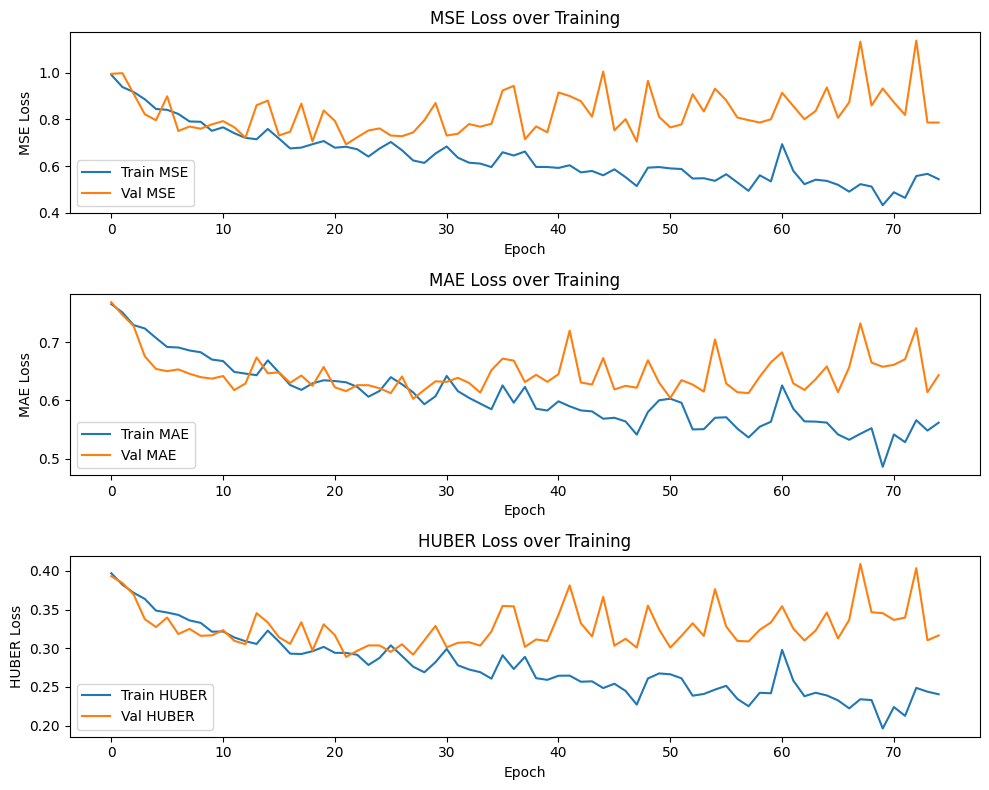

In [19]:

# Plot losses for each metric
plt.figure(figsize=(10, 8))

for i, (name, losses) in enumerate(train_losses.items()):
    plt.subplot(len(train_losses), 1, i+1)
    plt.plot(losses, label=f'Train {name.upper()}')
    plt.plot(val_losses[name], label=f'Val {name.upper()}')
    plt.xlabel("Epoch")
    plt.ylabel(f"{name.upper()} Loss")
    plt.legend()
    plt.title(f"{name.upper()} Loss over Training")

plt.tight_layout()
plt.show()





#### 7) Evaluation on Test Set and Additional Metrics




In [20]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        # Detach and move to CPU; flatten the predictions.
        preds = outputs.cpu().numpy().flatten()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Spearman's rank correlation coefficient (SROCC)
spearman_corr, _ = spearmanr(all_labels, all_preds)

# Compute Mean Absolute Error (MAE)
mae_val = mean_absolute_error(all_labels, all_preds)

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(all_labels, all_preds)
# Compute R² score
r2_val = r2_score(all_labels, all_preds)

print(f"SROCC:    {spearman_corr:.4f}")
print(f"Pearson:  {pearson_corr:.4f}")
print(f"R^2:      {r2_val:.4f}")
print(f"MAE: {mae_val:.4f}")




SROCC:    0.6216
Pearson:  0.6944
R^2:      0.4593
MAE: 0.5105


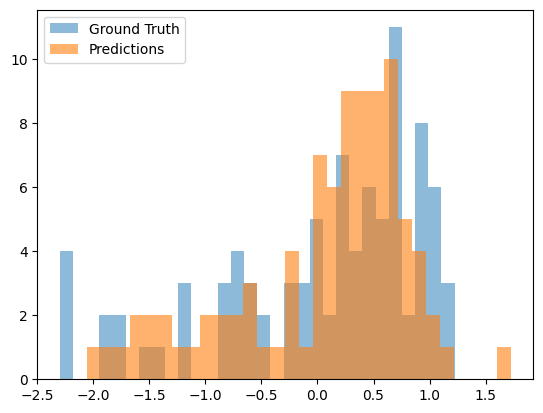

In [21]:
import matplotlib.pyplot as plt

plt.hist(all_labels, bins=30, alpha=0.5, label='Ground Truth')
plt.hist(all_preds, bins=30, alpha=0.6, label='Predictions')
plt.legend()
plt.show()


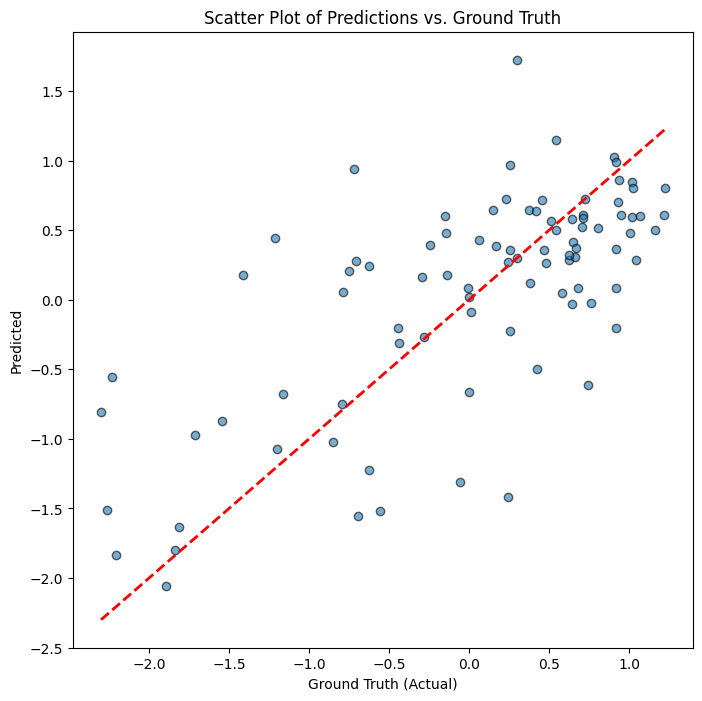

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.6, edgecolors='k')
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', lw=2)
plt.xlabel('Ground Truth (Actual)')
plt.ylabel('Predicted')
plt.title('Scatter Plot of Predictions vs. Ground Truth')
plt.show()


In [23]:
# Save only the model weights (state_dict)
import datetime

# Format: YYYY-MM-DD_HH-MM-SS
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_time_%H-%M-%S")
print(f"Current timestamp for filename: {timestamp}")

model_name = 'baseCNN'

torch.save(model.state_dict(), f'./weights/{model_name}_{timestamp}_SROCC_{int(spearman_corr*100)}_Pearson_{int(pearson_corr*100)}.pth')


Current timestamp for filename: 2025-05-25_time_00-51-37
